In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm
import flopy
import flopy.utils.binaryfile as bf
%matplotlib inline
%config InlineBackend.figure_format='retina'
import rasterio
from tqdm import tqdm
from scipy.ndimage import maximum_filter
from scipy.interpolate import griddata

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [2]:
import sys
sys.path.append('../scripts/')
from Slate_Floodplain_MODFLOW import *

In [3]:
ncol = 480
nrow = 460

nlay = 16
soil_nlay = 10
gravel_nlay = nlay - soil_nlay
dam_nlay = 5

# setting up the vertical discretization and model bottom elevation
zbot = np.zeros((nlay,nrow,ncol))

# Soil layers
for lay in np.arange(0,soil_nlay):    
    zbot[lay,:,:] = DEM - np.maximum(gravel_interface*((lay+1)/soil_nlay),0.1*(lay+1)) 

# Gravel layers
gravel_discretized_ratio = [0.02,0.04,0.1,0.3,0.6,1]
for i, lay in enumerate(np.arange(soil_nlay, nlay)):
    zbot[lay,:,:] = zbot[soil_nlay-1,:,:] - np.maximum(bedrock_interface*gravel_discretized_ratio[i],0.1*(i+1))
    
thickness = np.zeros(zbot.shape)
for i in range(nlay):
    if i == 0:
        thickness[i,:,:] = DEM-zbot[i,:,:]
    else:
        thickness[i,:,:] = zbot[i-1,:,:]-zbot[i,:,:]
depth_to_surface = DEM-zbot

In [4]:
# Default values 
hk_gravel = 2e-3 #m/s
hk_soil = 1.4e-5 #m/s
vka_ratio_gravel = 0.5 #m/s
vka_ratio_soil = 0.1 #m/s
k_dam = 1e-7 #m/s

precip = 2e-3 #m/d
ET = 2e-3 #m/d

In [5]:
mf,head,hk,vka,strt,zbot,flf,frf = modflow_BC(hk_gravel,hk_soil,vka_ratio_gravel,vka_ratio_soil,k_dam,
                                              ET,precip, 'test', './baseflow_test')

/Users/lwang/anaconda3/envs/watershed_workflow-2022-08-29/lib/python3.10/site-packages/flopy/utils/crs.py:122: PendingDeprecationWarning: the epsg argument will be deprecated and will be removed in version 3.6. Use crs instead.
  warnings.warn(


FloPy is using the following executable to run the model: ../../../../../.local/share/flopy/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: test.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/10/10 12:23:58

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/10/10 12:25:11
 Elapsed run time:  1 Minutes, 12.394 Seconds

  Normal termination of simulation


# Local and Global responses: downward and horizontal

In [26]:
downstream = np.load('../data/characterization_data/Beaver_pond_dam/floodplain_downstream.npy')
upstream = np.load('../data/characterization_data/Beaver_pond_dam/floodplain_upstream.npy')
downstream[:,300:] = 0

In [10]:
# Downward flow on top of gravel bed (river)
def dw_river(flf):
    spatial_mask = (river+pond-dam ==2)
    velocity = flf[soil_nlay-1,:,:]*spatial_mask
    return velocity

# Downward flow on top of soil layer (floodplain)
def dw_floodplain(flf):
    spatial_mask = (upstream+downstream==1)
    velocity = flf[soil_nlay-1,:,:]*spatial_mask
    return velocity

# Horizontal flow though dam cross section (river)
def h_dam_river(frf,dam_section = 240):
    velocity = (frf/thickness)[:,:,dam_section]
    line_mask = np.zeros(frf.shape[1])
    line_mask[np.where((river+pond-dam ==2))[0].min():(np.where((river+pond-dam ==2))[0].max()+2)] = 1
    spatial_mask = line_mask[np.newaxis, :]==1
    velocity = velocity*spatial_mask
    return velocity

# Horizontal flow though dam cross section (floodplain)
def h_dam_floodplain(frf,dam_section = 240):
    velocity = (frf/thickness)[:,:,dam_section]
    spatial_mask = (upstream+downstream)[:,dam_section][np.newaxis, :]==1
    velocity = velocity*spatial_mask
    return velocity

In [11]:
def local_regional_response(flf,frf):
    dam_section = 240
    dw_r = dw_river(flf)
    dw_f = dw_floodplain(flf)
    h_v_r = h_dam_river(frf)
    h_v_f = h_dam_floodplain(frf)
    h_flux_r = h_v_r*thickness[:,:,dam_section]
    h_flux_f = h_v_f*thickness[:,:,dam_section]
    return dw_r,dw_f,h_v_r,h_v_f,h_flux_r,h_flux_f

In [10]:
forcings = pd.read_csv('../data/response_data/preprocessing/period_forcings.csv')

# Result for the calibrated baseflow

In [ ]:
num_MC = 300

all_dw_r = np.zeros((num_MC, nrow,ncol))
all_dw_f = np.zeros((num_MC, nrow,ncol))
all_h_v_r = np.zeros((num_MC,nlay, nrow))
all_h_v_f = np.zeros((num_MC,nlay, nrow))
all_h_flux_r = np.zeros((num_MC,nlay, nrow))
all_h_flux_f = np.zeros((num_MC,nlay, nrow))
all_head = np.zeros((num_MC,nlay, nrow,ncol))

for i in tqdm(range(num_MC)):
    head,flf,frf = read_sim('./Posterior_Simulation/sim'+str(i).zfill(3),'sim'+str(i).zfill(3))
    all_head[i,:]  = head
    # Calculate responses for current case
    dw_r_i, dw_f_i, h_v_r_i, h_v_f_i, h_flux_r_i, h_flux_f_i = local_regional_response(flf, frf)

    # Store results in arrays
    all_dw_r[i, :] = dw_r_i
    all_dw_f[i, :] = dw_f_i
    all_h_v_r[i] = h_v_r_i
    all_h_v_f[i] = h_v_f_i
    all_h_flux_r[i, :] = h_flux_r_i
    all_h_flux_f[i, :] = h_flux_f_i

In [ ]:
row_idx = 197
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=mf, line={'Row': row_idx})
modelxsect.plot_array(np.mean(all_head,axis = 0),cmap = 'magma',vmin = 2724,vmax = 2726)
modelxsect.contour_array(np.mean(all_head,axis = 0),cmap = 'Greys_r',levels=np.linspace(2724, 2726, 20))
#linecollection = modelxsect.plot_grid(color = 'black')
plt.xticks([])
#plt.hlines(y = 2725.7,xmin = 202,xmax = 236,linestyles='--',color = 'blue',label = 'Pond level: baseflow')
#plt.legend()
plt.locator_params(axis="y", nbins=2)
plt.ylabel('Elevation (m)')

plt.ylim(2702,2730)
plt.xlim(100,350)

(-0.5, 479.5, 459.5, -0.5)

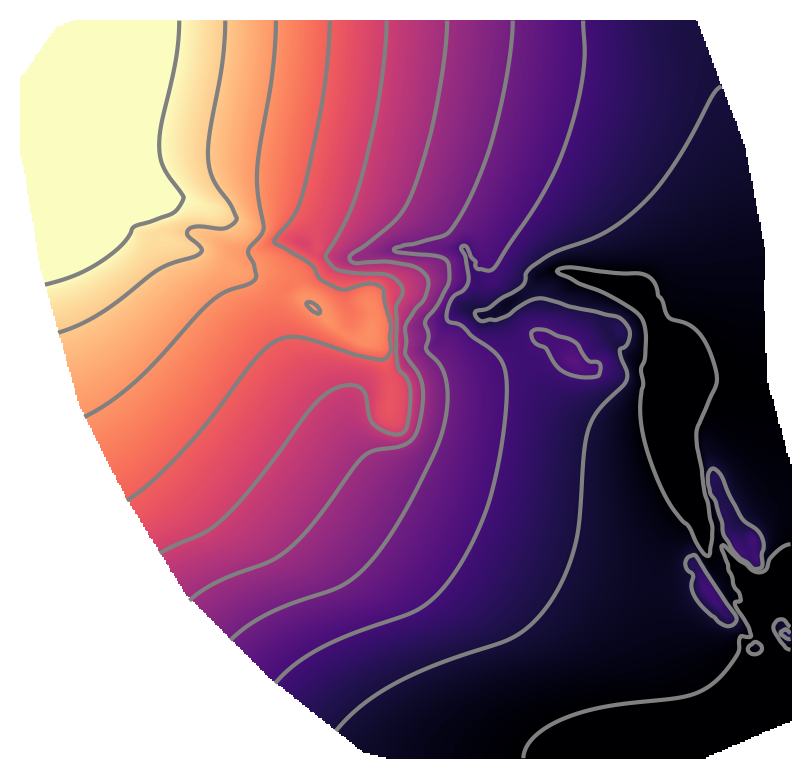

In [21]:
# Assuming 'all_head' is your data array
data = np.mean(all_head, axis=0)[5, :, :]
data[data<0] = np.nan
# Plot the image
plt.imshow(data, cmap='magma', vmin=2724, vmax=2726)

# Add contour lines
contour_levels = np.linspace(2724, 2726, 10)  # Adjust the number of contour levels as needed
plt.contour(data, levels=contour_levels, colors='grey')

plt.axis('off')
#plt.colorbar()  # Add colorbar for reference


(-0.5, 479.5, 459.5, -0.5)

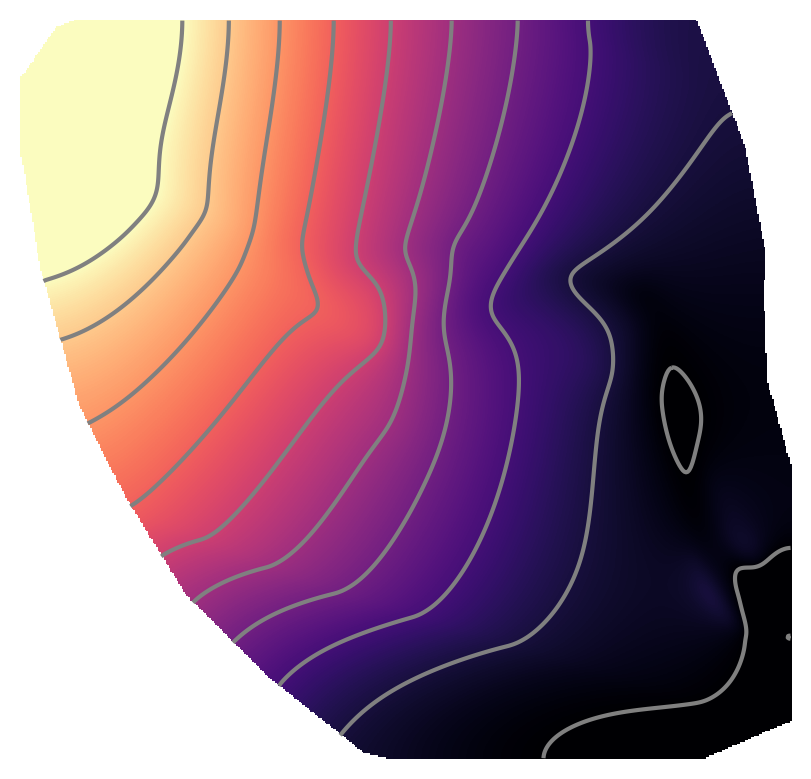

In [22]:
# Assuming 'all_head' is your data array
data = np.mean(all_head, axis=0)[13, :, :]
data[data<0] = np.nan
# Plot the image
plt.imshow(data, cmap='magma', vmin=2724, vmax=2726)

# Add contour lines
contour_levels = np.linspace(2724, 2726, 10)  # Adjust the number of contour levels as needed
plt.contour(data, levels=contour_levels, colors='grey')

plt.axis('off')
#plt.colorbar()  # Add colorbar for reference


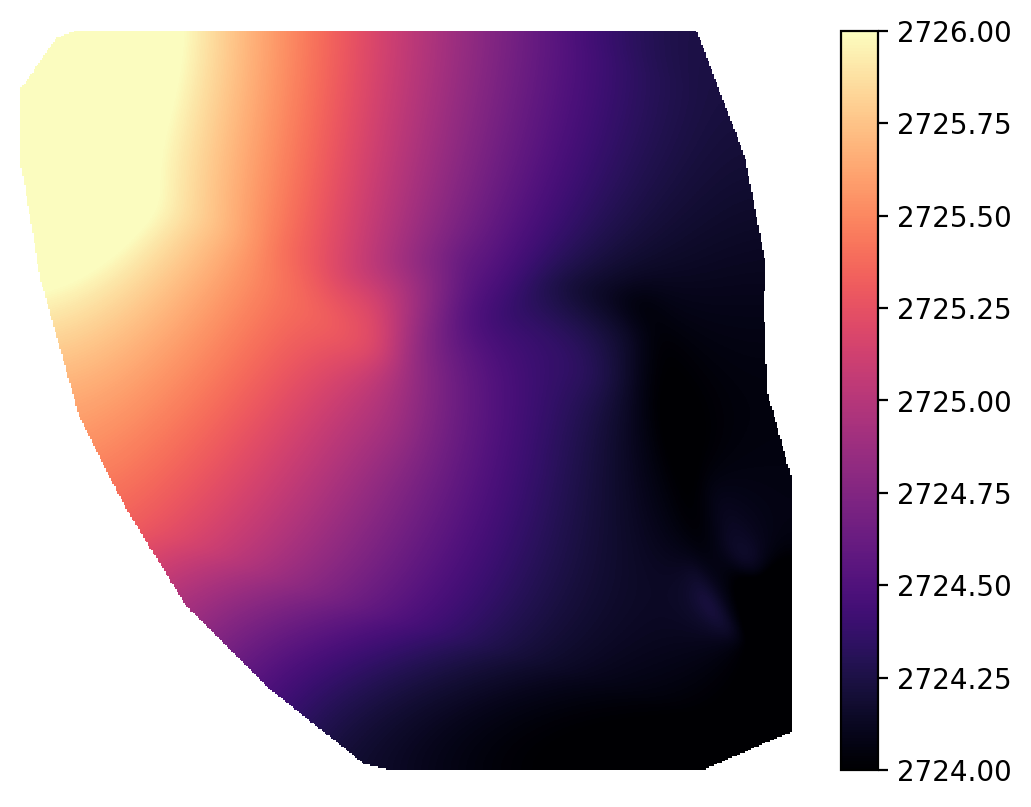

In [23]:
# Assuming 'all_head' is your data array
data = np.mean(all_head, axis=0)[13, :, :]
data[data<0] = np.nan
# Plot the image
plt.imshow(data, cmap='magma', vmin=2724, vmax=2726)

# Add contour lines
contour_levels = np.linspace(2724, 2726, 10)  # Adjust the number of contour levels as needed
#plt.contour(data, levels=contour_levels, colors='grey')

plt.axis('off')
plt.colorbar()  # Add colorbar for reference


In [30]:
all_dw_f_baseflow = all_dw_f

In [32]:
spd = 60*60*24
all_dw_r_sum = np.sum((all_dw_r*(all_dw_r>0)).reshape(num_MC,-1),axis = 1)/spd
all_dw_f_sum = np.sum((all_dw_f*(all_dw_f>0)).reshape(num_MC,-1),axis = 1)/spd
all_h_flux_r_sum = np.sum((all_h_flux_r*(all_h_flux_r>0)).reshape(num_MC,-1),axis = 1)/spd
all_h_flux_f_sum = np.sum((all_h_flux_f*(all_h_flux_f>0)).reshape(num_MC,-1),axis = 1)/spd

In [33]:
all_dw_f_area = (all_dw_f>0)*1
all_dw_f_area_sum = np.sum(((all_dw_f>0)).reshape(num_MC,-1),axis = 1)

In [34]:
flux = pd.DataFrame(np.array([all_dw_r_sum,all_dw_f_sum,all_h_flux_r_sum,all_h_flux_f_sum,all_dw_f_area_sum]).T)

# Define new column names
new_columns = ['$Q_z^r$', '$Q_z^f$', '$Q_x^r$', '$Q_x^f$','$Q_z^f$']

# Rename columns
flux.columns = new_columns


# # Melt the DataFrame to convert it to long format
# flux = flux.melt(var_name='Columns', value_name='Flux (m3/s)')


# colors = ["C0", "purple", "lightblue", "#d8bfd8"]  #]  # Example colors, you can specify your own
# sns.set_palette(sns.color_palette(colors))

# # Create a box plot using Seaborn
# plt.figure(figsize=(4, 4))  # Adjust figure size if needed
# ax = sns.boxplot(x='Columns', y='Flux (m3/s)', data=flux)

# plt.yscale('log')  # Set y-axis to logarithmic scale
# plt.xlabel('')

# Result for snowmelt and dry pond

In [89]:
num_MC = 300

all_dw_r = np.zeros((num_MC, nrow,ncol))
all_dw_f = np.zeros((num_MC, nrow,ncol))
all_h_v_r = np.zeros((num_MC,nlay, nrow))
all_h_v_f = np.zeros((num_MC,nlay, nrow))
all_h_flux_r = np.zeros((num_MC,nlay, nrow))
all_h_flux_f = np.zeros((num_MC,nlay, nrow))

for i in tqdm(range(num_MC)):
    head,flf,frf = read_sim('./Posterior_Simulation_Snowmelt/sim'+str(i).zfill(3),'sim'+str(i).zfill(3))

    # Calculate responses for current case
    dw_r_i, dw_f_i, h_v_r_i, h_v_f_i, h_flux_r_i, h_flux_f_i = local_regional_response(flf, frf)

    # Store results in arrays
    all_dw_r[i, :] = dw_r_i
    all_dw_f[i, :] = dw_f_i
    all_h_v_r[i] = h_v_r_i
    all_h_v_f[i] = h_v_f_i
    all_h_flux_r[i, :] = h_flux_r_i
    all_h_flux_f[i, :] = h_flux_f_i

100%|█████████████████████████████████████████| 300/300 [00:07<00:00, 41.35it/s]


In [90]:
all_dw_f_snowmelt = all_dw_f

In [91]:
spd = 60*60*24
all_dw_r_sum = np.sum((all_dw_r*(all_dw_r>0)).reshape(num_MC,-1),axis = 1)/spd
all_dw_f_sum = np.sum((all_dw_f*(all_dw_f>0)).reshape(num_MC,-1),axis = 1)/spd
all_h_flux_r_sum = np.sum((all_h_flux_r*(all_h_flux_r>0)).reshape(num_MC,-1),axis = 1)/spd
all_h_flux_f_sum = np.sum((all_h_flux_f*(all_h_flux_f>0)).reshape(num_MC,-1),axis = 1)/spd

In [92]:
all_dw_f_area_snowmelt = (all_dw_f>0)*1
all_dw_f_area_sum = np.sum(((all_dw_f>0)).reshape(num_MC,-1),axis = 1)

In [93]:
flux_snowmelt = pd.DataFrame(np.array([all_dw_r_sum,all_dw_f_sum,all_h_flux_r_sum,all_h_flux_f_sum,all_dw_f_area_sum]).T)

# Define new column names
new_columns = ['$q_z^r$', '$q_z^f$', '$q_x^r$', '$q_x^f$','$A_z^f$']

# Rename columns
flux_snowmelt.columns = new_columns

# # Melt the DataFrame to convert it to long format
# flux = flux.melt(var_name='Columns', value_name='Flux (m3/s)')


# colors = ["C0", "purple", "lightblue", "#d8bfd8"]  #]  # Example colors, you can specify your own
# sns.set_palette(sns.color_palette(colors))

# # Create a box plot using Seaborn
# plt.figure(figsize=(4, 4))  # Adjust figure size if needed
# ax = sns.boxplot(x='Columns', y='Flux (m3/s)', data=flux)

# plt.yscale('log')  # Set y-axis to logarithmic scale
# plt.xlabel('')

In [36]:
num_MC = 300

all_dw_r = np.zeros((num_MC, nrow,ncol))
all_dw_f = np.zeros((num_MC, nrow,ncol))
all_h_v_r = np.zeros((num_MC,nlay, nrow))
all_h_v_f = np.zeros((num_MC,nlay, nrow))
all_h_flux_r = np.zeros((num_MC,nlay, nrow))
all_h_flux_f = np.zeros((num_MC,nlay, nrow))

for i in tqdm(range(num_MC)):
    head,flf,frf = read_sim('./Posterior_Simulation_Drypond/sim'+str(i).zfill(3),'sim'+str(i).zfill(3))

    # Calculate responses for current case
    dw_r_i, dw_f_i, h_v_r_i, h_v_f_i, h_flux_r_i, h_flux_f_i = local_regional_response(flf, frf)

    # Store results in arrays
    all_dw_r[i, :] = dw_r_i
    all_dw_f[i, :] = dw_f_i
    all_h_v_r[i] = h_v_r_i
    all_h_v_f[i] = h_v_f_i
    all_h_flux_r[i, :] = h_flux_r_i
    all_h_flux_f[i, :] = h_flux_f_i

100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 44.99it/s]


In [37]:
all_dw_f_dry = all_dw_f

In [42]:
spd = 60*60*24
all_dw_r_sum = np.sum((all_dw_r*(all_dw_r>0)).reshape(num_MC,-1),axis = 1)/spd
all_dw_f_sum = np.sum((all_dw_f*(all_dw_f>0)).reshape(num_MC,-1),axis = 1)/spd
all_h_flux_r_sum = np.sum((all_h_flux_r*(all_h_flux_r>0)).reshape(num_MC,-1),axis = 1)/spd
all_h_flux_f_sum = np.sum((all_h_flux_f*(all_h_flux_f>0)).reshape(num_MC,-1),axis = 1)/spd

In [43]:
all_dw_f_area_dry_pond = (all_dw_f>0)*1
all_dw_f_area_sum = np.sum(((all_dw_f>0)).reshape(num_MC,-1),axis = 1)

In [44]:
flux_dry = pd.DataFrame(np.array([all_dw_r_sum,all_dw_f_sum,all_h_flux_r_sum,all_h_flux_f_sum,all_dw_f_area_sum]).T)

# Define new column names
new_columns = ['$Q_z^r$', '$Q_z^f$', '$Q_x^r$', '$Q_x^f$','$A_z^f$']

# Rename columns
flux_dry.columns = new_columns

In [102]:
pond = np.load('../data/characterization_data/Beaver_pond_dam/pond_baseflow.npy')
pond_snow = np.load('../data/characterization_data/Beaver_pond_dam/pond_snowmelt.npy')

<>:8: DeprecationWarning: invalid escape sequence '\l'
<>:8: DeprecationWarning: invalid escape sequence '\l'
/var/folders/h0/75yxxdws6n1gdlgpdhf6470r0000gp/T/ipykernel_51483/2406833133.py:8: DeprecationWarning: invalid escape sequence '\l'
  plt.xlabel('$\log(K_{v})$')


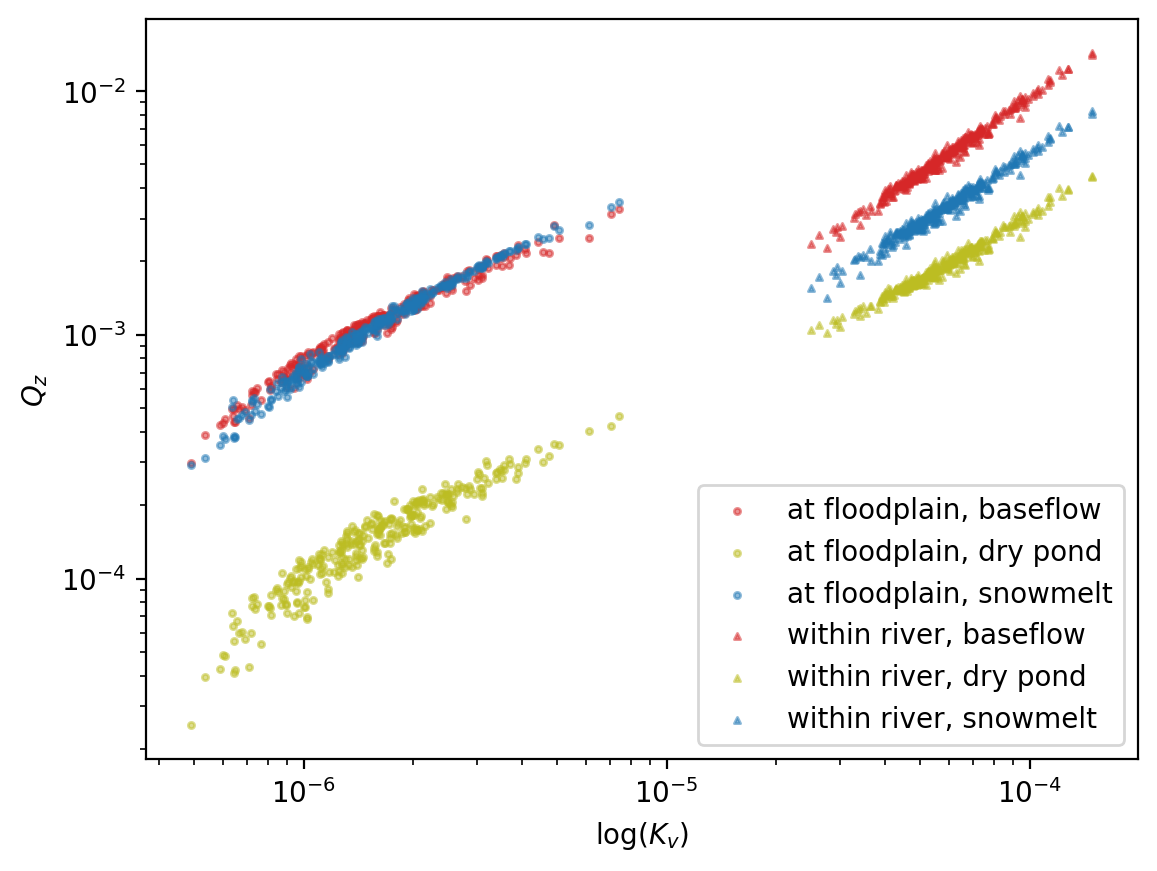

In [135]:
plt.scatter((paras['hk_soil']*paras['vka_ratio_soil']),flux['$q_z^f$'],s = 10,marker='o',color = 'C3',alpha = 0.5,label = 'at floodplain, baseflow')
plt.scatter((paras['hk_soil']*paras['vka_ratio_soil']),flux_dry['$q_z^f$'],s = 10,marker='o',color = 'C8',alpha = 0.5,label = 'at floodplain, dry pond')
plt.scatter((paras['hk_soil']*paras['vka_ratio_soil']),flux_snowmelt['$q_z^f$'],s = 10,marker='o',color = 'C0',alpha = 0.5,label = 'at floodplain, snowmelt')
plt.scatter((paras['hk_gravel']*paras['vka_ratio_gravel']),flux['$q_z^r$'],s = 10,marker='^',color = 'C3',alpha = 0.5,label = 'within river, baseflow')
plt.scatter((paras['hk_gravel']*paras['vka_ratio_gravel']),flux_dry['$q_z^r$'],s = 10,marker='^',color = 'C8',alpha = 0.5,label = 'within river, dry pond')
plt.scatter((paras['hk_gravel']*paras['vka_ratio_gravel']),flux_snowmelt['$q_z^r$'],s = 10,marker='^',color = 'C0',alpha = 0.5,label = 'within river, snowmelt')

plt.xlabel('$\log(K_{v})$')
plt.ylabel('$Q_z$')
plt.yscale('log') 
plt.xscale('log') 
plt.legend()

In [66]:
paras = pd.read_csv('Posterior_Simulation/Posterior_Parameters.csv')
paras = paras.iloc[:300,:]
#paras = np.log10(paras)

In [182]:
from DGSA_light import DGSA_light
from gsa_pareto_plt import gsa_pareto_plt

In [34]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - 0) / (1 - 0)
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [222]:
posterior_samples = pd.read_csv('Posterior_Simulation/Posterior_Parameters.csv')
posterior_samples = posterior_samples[posterior_samples.columns[1:]]

# Result for varying: structure, ET, precip, ponding period, K

In [2]:
parameters = pd.read_csv('./Simulation_More_Variations/Parameters.csv')

In [4]:
parameters['period'] = pd.factorize(parameters['period'])[0]

In [5]:
log_paras = parameters[parameters.columns[:-1]]

In [6]:
log_paras[log_paras.columns[:5]] = np.log10(log_paras[log_paras.columns[:5]])

/var/folders/bc/n9nbnrrd1m1gttddqb1hzyt00000gp/T/ipykernel_38126/213575839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_paras[log_paras.columns[:5]] = np.log10(log_paras[log_paras.columns[:5]])


In [18]:
def thickness_from_ratio(structure_ratio1,structure_ratio2):
    # setting up the vertical discretization and model bottom elevation
    zbot = np.zeros((nlay,nrow,ncol))
    
    # Soil layers
    for lay in np.arange(0,soil_nlay):    
        zbot[lay,:,:] = DEM - np.maximum(gravel_interface*structure_ratio1*((lay+1)/soil_nlay),0.1*(lay+1)) 
    
    # Gravel layers
    gravel_discretized_ratio = [0.02,0.04,0.1,0.3,0.6,1]
    for i, lay in enumerate(np.arange(soil_nlay, nlay)):
        zbot[lay,:,:] = zbot[soil_nlay-1,:,:] - np.maximum(bedrock_interface*structure_ratio2*gravel_discretized_ratio[i],0.1*(i+1))

    thickness = np.zeros(zbot.shape)
    for i in range(nlay):
        if i == 0:
            thickness[i,:,:] = DEM-zbot[i,:,:]
        else:
            thickness[i,:,:] = zbot[i-1,:,:]-zbot[i,:,:]
    return thickness

In [19]:
def local_regional_response_structure_change(flf,frf, structure_ratio1,structure_ratio2):
    thickness = thickness_from_ratio(structure_ratio1,structure_ratio2)
    dam_section = 240
    dw_r = dw_river(flf)
    dw_f = dw_floodplain(flf)
    h_v_r = h_dam_river(frf)
    h_v_f = h_dam_floodplain(frf)
    h_flux_r = h_v_r*thickness[:,:,dam_section]
    h_flux_f = h_v_f*thickness[:,:,dam_section]
    return dw_r,dw_f,h_v_r,h_v_f,h_flux_r,h_flux_f

In [24]:
from tqdm import tqdm

In [28]:
num_MC = 500

all_dw_r = np.zeros((num_MC, nrow,ncol))
all_dw_f = np.zeros((num_MC, nrow,ncol))
all_h_v_r = np.zeros((num_MC,nlay, nrow))
all_h_v_f = np.zeros((num_MC,nlay, nrow))
all_h_flux_r = np.zeros((num_MC,nlay, nrow))
all_h_flux_f = np.zeros((num_MC,nlay, nrow))
all_head = np.zeros((num_MC,nlay, nrow,ncol))

for i in tqdm(range(num_MC)):
    if parameters['success'][i]==1:
        structure_ratio1 = parameters['structure_ratio1'][i]
        structure_ratio2 = parameters['structure_ratio2'][i]
        head,flf,frf = read_sim('./Simulation_More_Variations/sim'+str(i).zfill(3),'sim'+str(i).zfill(3))
        all_head[i,:]  = head
        # Calculate responses for current case
        dw_r_i, dw_f_i, h_v_r_i, h_v_f_i, h_flux_r_i, h_flux_f_i = local_regional_response_structure_change(flf, frf,structure_ratio1,structure_ratio2)

        # Store results in arrays
        all_dw_r[i, :] = dw_r_i
        all_dw_f[i, :] = dw_f_i
        all_h_v_r[i] = h_v_r_i
        all_h_v_f[i] = h_v_f_i
        all_h_flux_r[i, :] = h_flux_r_i
        all_h_flux_f[i, :] = h_flux_f_i

100%|█████████████████████████████████████████| 500/500 [00:25<00:00, 19.99it/s]


In [29]:
spd = 60*60*24 
all_dw_r_sum = np.sum((all_dw_r*(all_dw_r>0)).reshape(num_MC,-1),axis = 1)/spd #(m3/s)
all_dw_f_sum = np.sum((all_dw_f*(all_dw_f>0)).reshape(num_MC,-1),axis = 1)/spd
all_h_flux_r_sum = np.sum((all_h_flux_r*(all_h_flux_r>0)).reshape(num_MC,-1),axis = 1)/spd
all_h_flux_f_sum = np.sum((all_h_flux_f*(all_h_flux_f>0)).reshape(num_MC,-1),axis = 1)/spd

In [30]:
flux_all = pd.DataFrame(np.array([all_dw_r_sum,all_dw_f_sum,
                                  all_h_flux_r_sum,
                                  all_h_flux_f_sum]).T)

# Define new column names
new_columns = ['$Q_z^r$', '$Q_z^f$', '$Q_x^r$', '$Q_x^f$']

# Rename columns
flux_all.columns = new_columns

In [32]:
xlabel = ['log $K_{h}^{gravel}$','log $K_{h}^{soil}$',
          'log($K_{v}^{gravel}/K_{h}^{gravel}$)',
          'log($K_{v}^{soil}/K_{h}^{soil}$)','log $K^{dam}$',
          'ET', 'Precipitation','Periods','Soil thickness','Gravel thickness']

In [ ]:
variable = '$Q_z^f$'
dgsa_measures = DGSA_light(log_paras.values[parameters['success']==1,:], flux_all[variable].values.reshape(-1,1)[parameters['success']==1],
                           xlabel)

dgsa_measures['name'] = xlabel
dgsa_measures['sensitive'] = (dgsa_measures[0]>1)*1

dgsa_measures = dgsa_measures.sort_values(by=dgsa_measures.columns[0],ascending=False)

In [ ]:
plt.figure(figsize=(2, 3)) 
sns.barplot(x = 0,y = 'name', data=dgsa_measures,palette = colors_from_values(dgsa_measures['sensitive'], "RdBu_r"))
plt.vlines(x = 1, ymin = -1, ymax = len(log_paras.columns),color = 'black',linestyle = '--')
plt.xlabel('Sensitivity measurement')
plt.ylabel('')
plt.xlim(0,5)
plt.title(variable)

In [84]:
variable = '$Q_z^f$'
dgsa_measures = DGSA_light(log_paras.values[parameters['success']==1,:], 
                           flux_all[variable].values.reshape(-1,1)[parameters['success']==1]/flux_all['$Q_x^f$'].values.reshape(-1,1)[parameters['success']==1],
                           xlabel)

dgsa_measures['name'] = xlabel
dgsa_measures['sensitive'] = (dgsa_measures[0]>1)*1

dgsa_measures = dgsa_measures.sort_values(by=dgsa_measures.columns[0],ascending=False)

100%|██████████████████████████████████████| 3000/3000 [00:11<00:00, 266.84it/s]


Text(0.5, 1.0, '$Q_z^f$/$Q_x^f$')

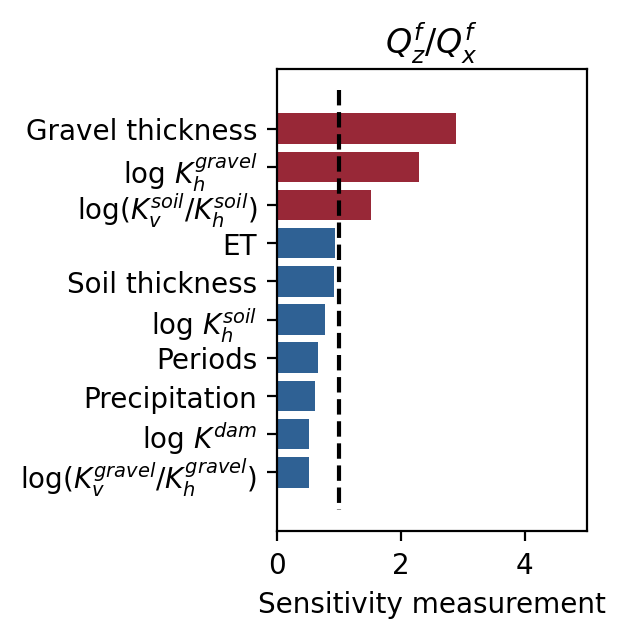

In [85]:
plt.figure(figsize=(2, 3)) 
sns.barplot(x = 0,y = 'name', data=dgsa_measures,palette = colors_from_values(dgsa_measures['sensitive'], "RdBu_r"))
plt.vlines(x = 1, ymin = -1, ymax = len(log_paras.columns),color = 'black',linestyle = '--')
plt.xlabel('Sensitivity measurement')
plt.ylabel('')
plt.xlim(0,5)
plt.title(variable+'/$Q_x^f$')

## Spatial sensitivity analysis

In [15]:
log_paras = log_paras.drop(columns=['period'])

In [16]:
xlabel = ['log $K_{h}^{gravel}$','log $K_{h}^{soil}$',
          'log($K_{v}^{gravel}/K_{h}^{gravel}$)',
          'log($K_{v}^{soil}/K_{h}^{soil}$)','log $K^{dam}$',
          'ET', 'Precipitation','Soil thickness','Gravel thickness']

In [ ]:
all_dw_f_m_s = all_dw_f/spd

Text(0.5, 1.0, 'ET')

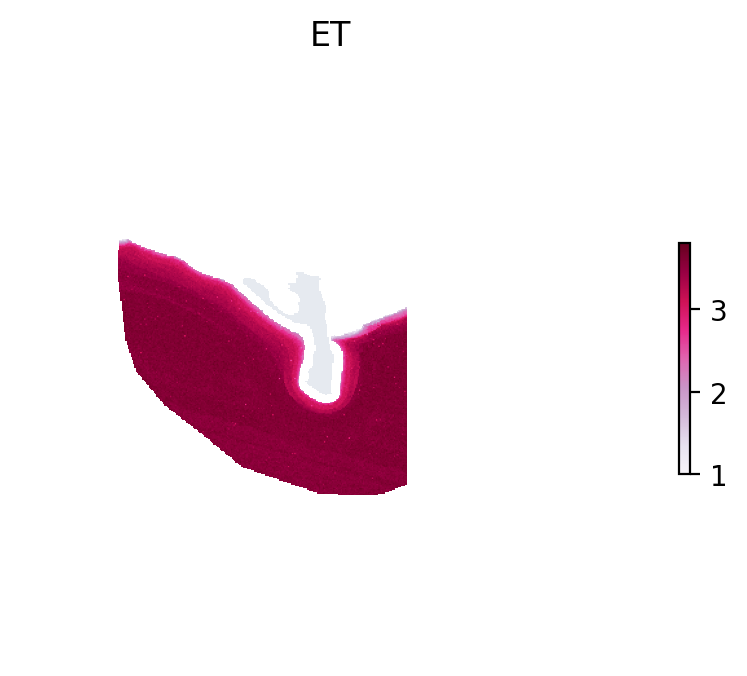

In [238]:
i = -4
plt.figure(figsize=[5,5])
pond_vis = np.array(np.copy(pond),dtype = 'float64')
pond_vis[pond_vis ==0] = np.nan
SA_matrix_vis = SA_matrix[i,:,:]
SA_matrix_vis[SA_matrix_vis<1] = np.nan
plt.imshow(SA_matrix_vis,vmin = 1,vmax = 3.8,cmap = 'PuRd')
plt.colorbar(shrink = 0.3)
plt.imshow(pond_vis,cmap = 'Blues_r',alpha = 0.1)
plt.axis('off')
plt.title(xlabel[i])

Text(0.5, 1.0, 'log $K_{h}^{soil}$')

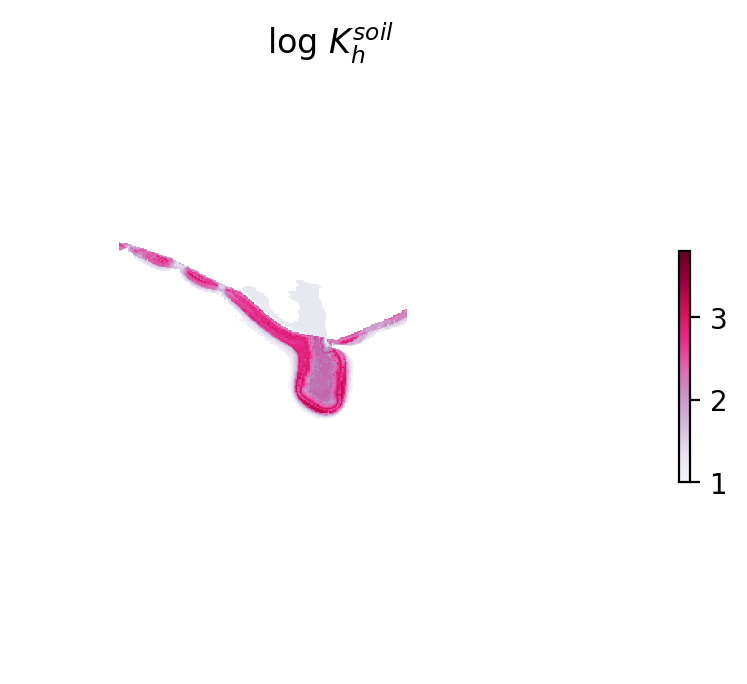

In [239]:
i = 1
plt.figure(figsize=[5,5])
pond_vis = np.array(np.copy(pond),dtype = 'float64')
pond_vis[pond_vis ==0] = np.nan
SA_matrix_vis = SA_matrix[i,:,:]
SA_matrix_vis[SA_matrix_vis<1] = np.nan
plt.imshow(SA_matrix_vis,vmin = 1,vmax = 3.8,cmap = 'PuRd')
plt.colorbar(shrink = 0.3)
plt.imshow(pond_vis,cmap = 'Blues_r',alpha = 0.1)
plt.axis('off')
plt.title(xlabel[i])

Text(0.5, 1.0, 'log($K_{v}^{soil}/K_{h}^{soil}$)')

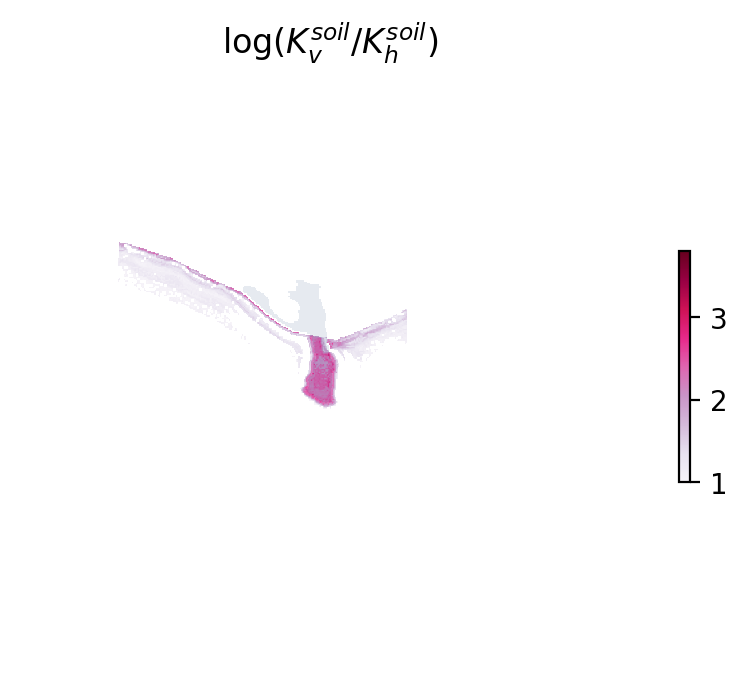

In [242]:
i = 3
plt.figure(figsize=[5,5])
pond_vis = np.array(np.copy(pond),dtype = 'float64')
pond_vis[pond_vis ==0] = np.nan
SA_matrix_vis = SA_matrix[i,:,:]
SA_matrix_vis[SA_matrix_vis<1] = np.nan
plt.imshow(SA_matrix_vis,vmin = 1,vmax = 3.8,cmap = 'PuRd')
plt.colorbar(shrink = 0.3)
plt.imshow(pond_vis,cmap = 'Blues_r',alpha = 0.1)
plt.axis('off')
plt.title(xlabel[i])

## Floodplain structures and ET

In [35]:
gravel_interface = np.load('../model/subsurface/predict_gravel.npy')
gravel_interface[np.isnan(gravel_interface)] = 0
bedrock_interface = np.load('../model/subsurface/predict_bedrock.npy')
bedrock_interface[np.isnan(bedrock_interface)] = 0


<>:20: DeprecationWarning: invalid escape sequence \l
<>:20: DeprecationWarning: invalid escape sequence \l
/var/folders/bc/n9nbnrrd1m1gttddqb1hzyt00000gp/T/ipykernel_38126/1840107691.py:20: DeprecationWarning: invalid escape sequence \l
  plt.colorbar(label='$\log(K_{v}^{soil})$')


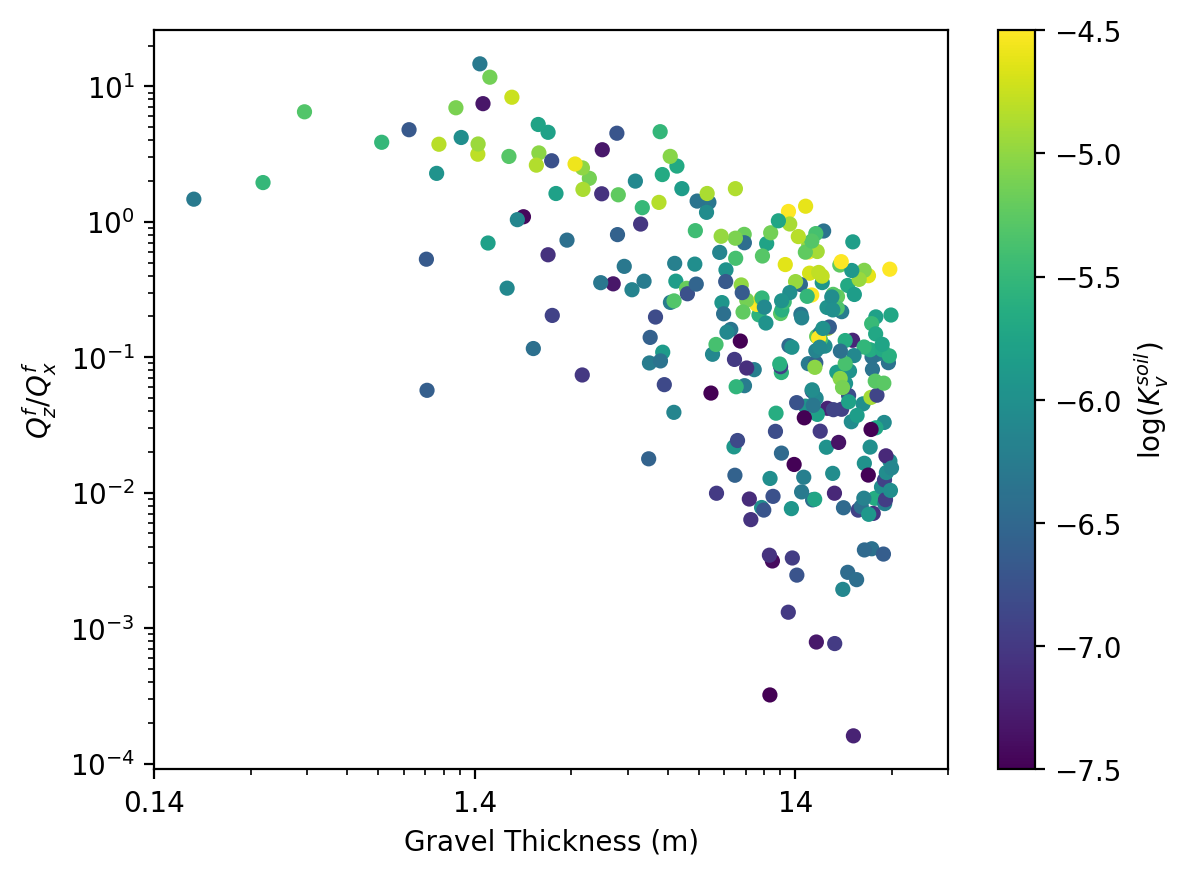

In [37]:
from matplotlib.ticker import FuncFormatter

# Assuming `parameters`, `all_dw_f_sum`, and `all_h_flux_f_sum` are already defined

# Filter out period == 1
filtered_parameters = parameters[parameters['period'] != 1]
structure_ratio2 = filtered_parameters['structure_ratio2']
hk_soil = filtered_parameters['hk_soil']
vka_ratio_soil = filtered_parameters['vka_ratio_soil']
hk_gravel = filtered_parameters['hk_gravel']

# Calculate the color array
color = np.log10(hk_soil * vka_ratio_soil )

# Calculate the y values for the scatter plot
y_values = (all_dw_f_sum / all_h_flux_f_sum)[parameters['period'] != 1]

# Create the scatter plot
plt.scatter(structure_ratio2, y_values,s = 20, c=color,vmin = -7.5,vmax = -4.5)
plt.colorbar(label='$\log(K_{v}^{soil})$')
plt.xlim(0.01,3)
plt.yscale('log') 
plt.xscale('log') 
plt.xlabel('Gravel Thickness (m)')
plt.ylabel('$Q_z^f/Q_x^f$')

# Define the custom formatter function
def custom_xaxis_formatter(x, pos):
    if x == 0.1:
        return '1.4'
    elif x == 1:
        return '14'
    elif x == 0.01:
        return '0.14'
    else:
        return f'{x}'

# Apply the custom formatter to the x-axis
formatter = FuncFormatter(custom_xaxis_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

# Show the plot
plt.show()


<>:20: DeprecationWarning: invalid escape sequence \l
<>:25: DeprecationWarning: invalid escape sequence \l
<>:20: DeprecationWarning: invalid escape sequence \l
<>:25: DeprecationWarning: invalid escape sequence \l
/var/folders/bc/n9nbnrrd1m1gttddqb1hzyt00000gp/T/ipykernel_38126/1601248449.py:20: DeprecationWarning: invalid escape sequence \l
  plt.colorbar(label='$\log(K_{v}^{soil}/K_{h}^{gravel})$')
/var/folders/bc/n9nbnrrd1m1gttddqb1hzyt00000gp/T/ipykernel_38126/1601248449.py:25: DeprecationWarning: invalid escape sequence \l
  plt.ylabel('$\log(Q_z^f/Q_x^f)$')


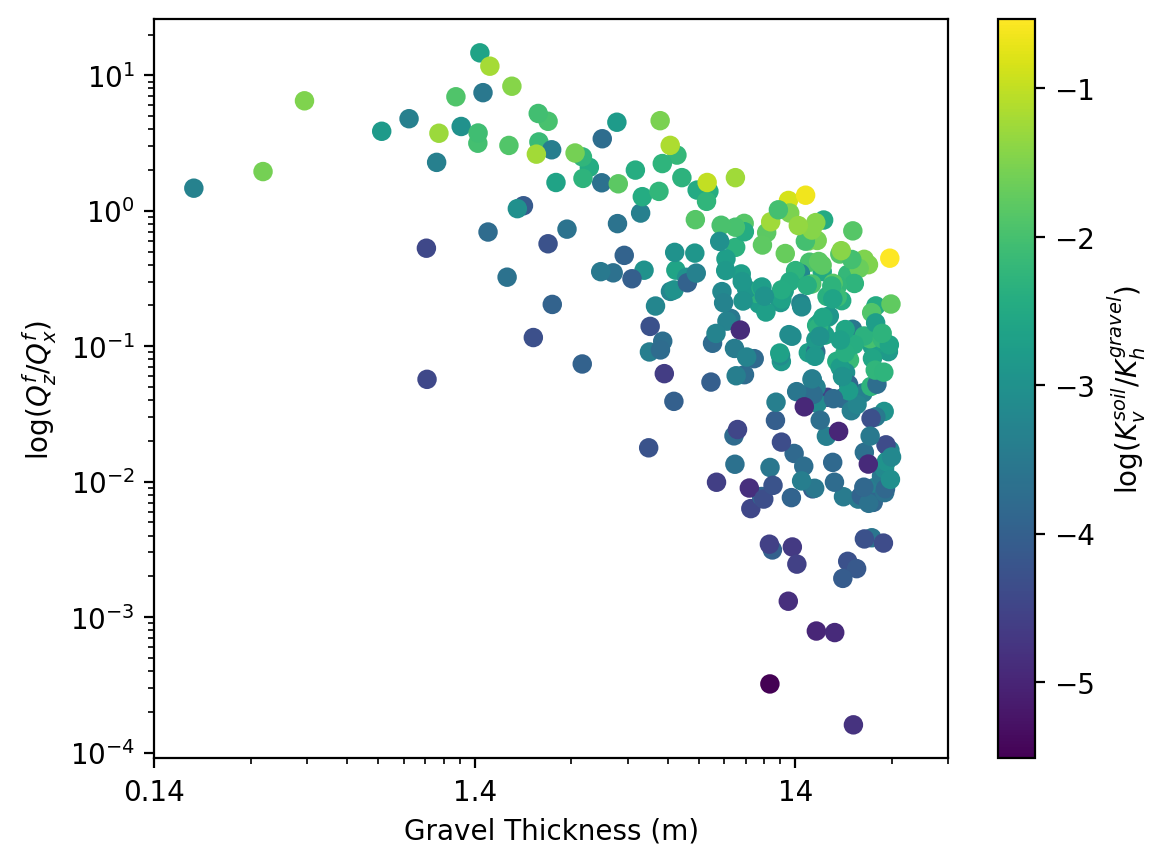

In [38]:
from matplotlib.ticker import FuncFormatter

# Assuming `parameters`, `all_dw_f_sum`, and `all_h_flux_f_sum` are already defined

# Filter out period == 1
filtered_parameters = parameters[parameters['period'] != 1]
structure_ratio2 = filtered_parameters['structure_ratio2']
hk_soil = filtered_parameters['hk_soil']
vka_ratio_soil = filtered_parameters['vka_ratio_soil']
hk_gravel = filtered_parameters['hk_gravel']

# Calculate the color array
color = np.log10(hk_soil * vka_ratio_soil / hk_gravel)

# Calculate the y values for the scatter plot
y_values = (all_dw_f_sum / all_h_flux_f_sum)[parameters['period'] != 1]

# Create the scatter plot
plt.scatter(structure_ratio2, y_values, c=color)
plt.colorbar(label='$\log(K_{v}^{soil}/K_{h}^{gravel})$')
plt.xlim(0.01,3)
plt.yscale('log') 
plt.xscale('log') 
plt.xlabel('Gravel Thickness (m)')
plt.ylabel('$\log(Q_z^f/Q_x^f)$')

# Define the custom formatter function
def custom_xaxis_formatter(x, pos):
    if x == 0.1:
        return '1.4'
    elif x == 1:
        return '14'
    elif x == 0.01:
        return '0.14'
    else:
        return f'{x}'

# Apply the custom formatter to the x-axis
formatter = FuncFormatter(custom_xaxis_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

# Show the plot
plt.show()


<>:14: DeprecationWarning: invalid escape sequence \ 
<>:14: DeprecationWarning: invalid escape sequence \ 
/var/folders/bc/n9nbnrrd1m1gttddqb1hzyt00000gp/T/ipykernel_38126/2814898130.py:14: DeprecationWarning: invalid escape sequence \ 
  plt.ylabel('$Q_z^f \ [m^3/s]$')


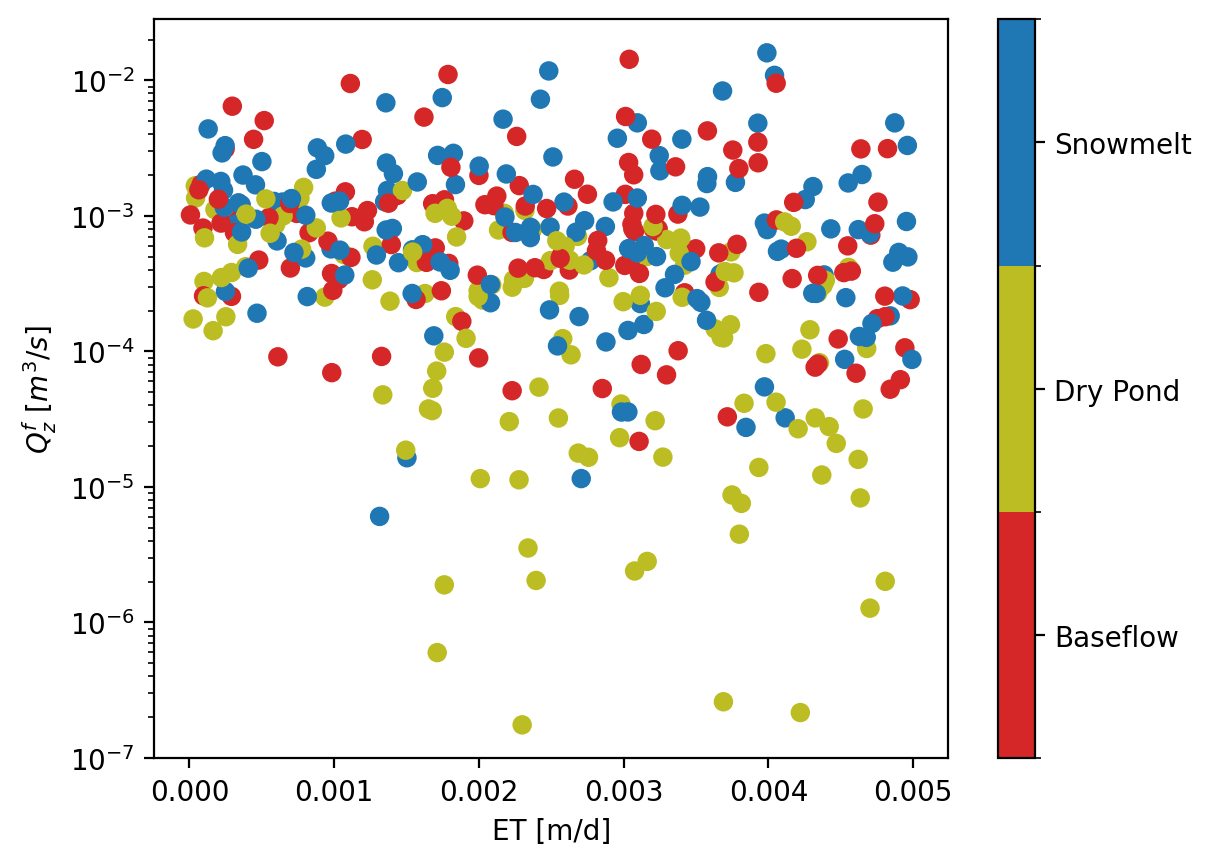

In [40]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define colors and labels for each category
colors = ['C3', 'C8', 'C0']  # Corresponding to 2: 'Snowmelt', 1: 'Dry Pond', 0: 'Baseflow'
labels = {0: 'Baseflow',1: 'Dry Pond', 2: 'Snowmelt' }
cmap = ListedColormap(colors)
bounds = [0, 1, 2, 3]  # Set boundaries for each category
norm = BoundaryNorm(bounds, cmap.N)

# Create the scatter plot
scatter = plt.scatter(parameters['ET'], all_dw_f_sum, c=parameters['period'], cmap=cmap, norm=norm)
plt.yscale('log')
plt.xlabel('ET [m/d]')
plt.ylabel('$Q_z^f \ [m^3/s]$')

# Create a color bar with appropriate labels for the periods
cbar = plt.colorbar(scatter, ticks=[0.5, 1.5, 2.5])  # Position the ticks between boundaries
cbar.ax.set_yticklabels([labels[0], labels[1], labels[2]])  # Apply labels

# Show the plot
plt.show()


<>:14: DeprecationWarning: invalid escape sequence \l
<>:14: DeprecationWarning: invalid escape sequence \l
/var/folders/bc/n9nbnrrd1m1gttddqb1hzyt00000gp/T/ipykernel_38126/2070708661.py:14: DeprecationWarning: invalid escape sequence \l
  plt.ylabel('$\log(Q_z^f) \ [m^3/s]$')


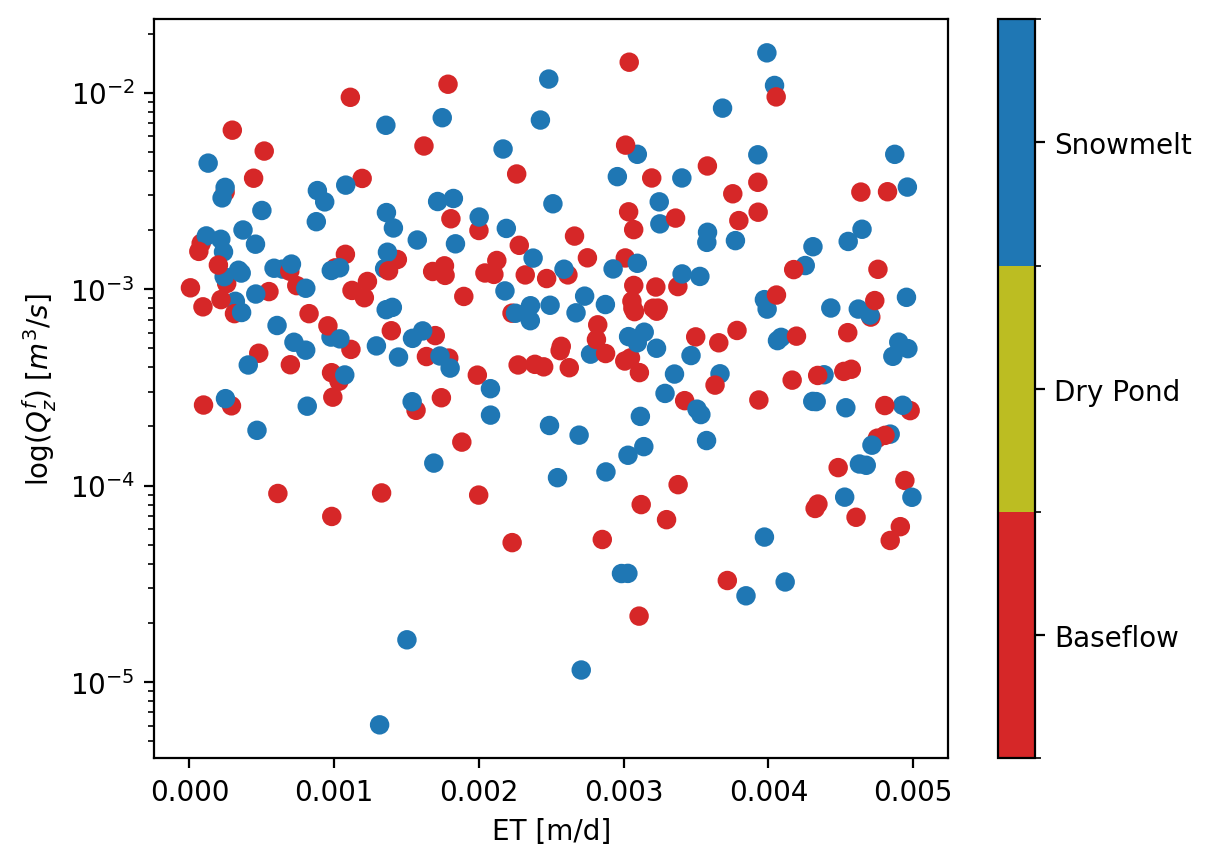

In [41]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define colors and labels for each category
colors = ['C3', 'C8', 'C0']  # Corresponding to 2: 'Snowmelt', 1: 'Dry Pond', 0: 'Baseflow'
labels = {0: 'Baseflow',1: 'Dry Pond', 2: 'Snowmelt' }
cmap = ListedColormap(colors)
bounds = [0, 1, 2, 3]  # Set boundaries for each category
norm = BoundaryNorm(bounds, cmap.N)

# Create the scatter plot
scatter = plt.scatter(parameters['ET'][parameters['period']!=1], all_dw_f_sum[parameters['period']!=1], c=parameters['period'][parameters['period']!=1], cmap=cmap, norm=norm)
plt.yscale('log')
plt.xlabel('ET [m/d]')
plt.ylabel('$\log(Q_z^f) \ [m^3/s]$')

# Create a color bar with appropriate labels for the periods
cbar = plt.colorbar(scatter, ticks=[0.5, 1.5, 2.5])  # Position the ticks between boundaries
cbar.ax.set_yticklabels([labels[0], labels[1], labels[2]])  # Apply labels

# Show the plot
plt.show()


In [43]:
pond = np.load('../data/characterization_data/Beaver_pond_dam/pond_baseflow.npy')
pond_sm = np.load('../data/characterization_data/Beaver_pond_dam/pond_snowmelt.npy')

In [44]:
pond_floodplain = ((pond+downstream+upstream)==2)*1
pond_floodplain_sm = ((pond_sm+downstream+upstream)==2)*1

In [45]:
correction_ET = np.zeros(500)
for i in range(500):
    if parameters['period'][i]==0:
        correction_ET[i] = np.sum(parameters['ET'][i]*pond_floodplain)/86400
    elif parameters['period'][i]==2:
        correction_ET[i] = np.sum(parameters['ET'][i]*pond_floodplain_sm)/86400

In [46]:
all_dw_f_corrected = np.zeros(all_dw_f.shape)
for i in range(500):
    if parameters['period'][i]==0:
        all_dw_f_corrected[i,:,:] = all_dw_f[i,:,:]-parameters['ET'][i]*pond_floodplain
    elif parameters['period'][i]==2:
        all_dw_f_corrected[i,:,:] = all_dw_f[i,:,:]-parameters['ET'][i]*pond_floodplain_sm

In [47]:
all_dw_f_corrected_sum = np.sum((all_dw_f_corrected*(all_dw_f_corrected>0)).reshape(num_MC,-1),axis = 1)/spd

In [48]:
data = {
    'corrected_Qzf': all_dw_f_corrected_sum,
    'Qzf': all_dw_f_sum
}

# Convert the arrays to a DataFrame
arrays_df = pd.DataFrame(data)

# Concatenate the DataFrame with parameters, ensuring correct alignment
combined_df = pd.concat([arrays_df, parameters], axis=1)
df =combined_df

In [49]:
df =combined_df

In [50]:
df_1_1_Qzf = df[(df['period'] == 1) & (df['success'] == 1)]['Qzf']
df_0_1_Qzf = df[(df['period'] == 0) & (df['success'] == 1)]['Qzf']
df_0_1_corrected_Qzf = df[(df['period'] == 0) & (df['success'] == 1)]['corrected_Qzf']
df_2_1_Qzf = df[(df['period'] == 2) & (df['success'] == 1)]['Qzf']
df_2_1_corrected_Qzf = df[(df['period'] == 2) & (df['success'] == 1)]['corrected_Qzf']

<>:45: DeprecationWarning: invalid escape sequence \l
<>:45: DeprecationWarning: invalid escape sequence \l
/var/folders/bc/n9nbnrrd1m1gttddqb1hzyt00000gp/T/ipykernel_38126/2141330254.py:45: DeprecationWarning: invalid escape sequence \l
  plt.ylabel('$\log(Q_z^f) \ [m^3/s]$')
/var/folders/bc/n9nbnrrd1m1gttddqb1hzyt00000gp/T/ipykernel_38126/2141330254.py:48: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 3 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(scatter, ticks=[0.5, 1.5, 2.5])


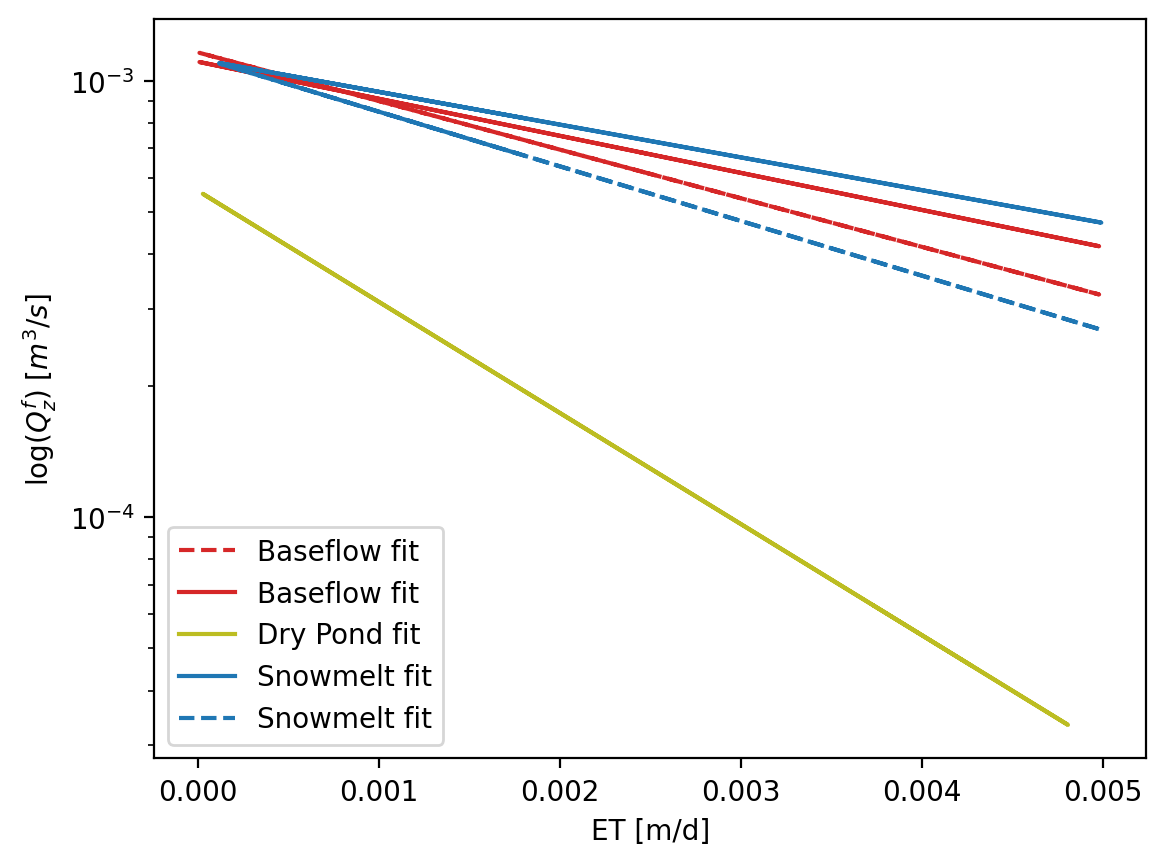

In [52]:
import numpy as np

# Fit linear lines for each period and plot them
# For Baseflow (period = 0)
baseflow_x = df[(df['period'] == 0) & (df['success'] == 1)]['ET']
baseflow_y = df[(df['period'] == 0) & (df['success'] == 1)]['corrected_Qzf']
baseflow_fit = np.polyfit(baseflow_x, np.log(baseflow_y), 1)  # Log scale fit
plt.plot(baseflow_x, np.exp(np.polyval(baseflow_fit, baseflow_x)), 'C3',linestyle = '--', label='Baseflow fit')


baseflow_x = df[(df['period'] == 0) & (df['success'] == 1)]['ET']
baseflow_y = df[(df['period'] == 0) & (df['success'] == 1)]['Qzf']
baseflow_fit = np.polyfit(baseflow_x, np.log(baseflow_y), 1)  # Log scale fit
plt.plot(baseflow_x, np.exp(np.polyval(baseflow_fit, baseflow_x)), 'C3', label='Baseflow fit')


# For Dry Pond (period = 1)
dry_pond_x = df[(df['period'] == 1) & (df['success'] == 1)]['ET']
dry_pond_y = df[(df['period'] == 1) & (df['success'] == 1)]['Qzf']
dry_pond_fit = np.polyfit(dry_pond_x, np.log(dry_pond_y), 1)  # Log scale fit
plt.plot(dry_pond_x, np.exp(np.polyval(dry_pond_fit, dry_pond_x)), 'C8', label='Dry Pond fit')


# For Snowmelt (period = 2)
snowmelt_x = df[(df['period'] == 2) & (df['success'] == 1)]['ET']
snowmelt_y = df[(df['period'] == 2) & (df['success'] == 1)]['Qzf']
snowmelt_fit = np.polyfit(snowmelt_x, np.log(snowmelt_y), 1)  # Log scale fit
plt.plot(snowmelt_x, np.exp(np.polyval(snowmelt_fit, snowmelt_x)), 'C0', label='Snowmelt fit')


# For Snowmelt (period = 2)
snowmelt_x = df[(df['period'] == 2) & (df['success'] == 1)]['ET']
snowmelt_y = df[(df['period'] == 2) & (df['success'] == 1)]['corrected_Qzf']
snowmelt_fit = np.polyfit(snowmelt_x, np.log(snowmelt_y), 1)  # Log scale fit
plt.plot(snowmelt_x, np.exp(np.polyval(snowmelt_fit, snowmelt_x)), 'C0',linestyle = '--', label='Snowmelt fit')

# Scatter plots (with fitted lines)
#plt.scatter(baseflow_x, baseflow_y, edgecolors='C3', c='C3', marker='^', label='Baseflow')
#plt.scatter(dry_pond_x, dry_pond_y, edgecolors='C8', c='C8', marker='o', label='Dry Pond')
#plt.scatter(snowmelt_x, snowmelt_y, edgecolors='C0', c='C0', marker='s', label='Snowmelt')

# Adding labels and color bar as before
plt.yscale('log')
plt.xlabel('ET [m/d]')
plt.ylabel('$\log(Q_z^f) \ [m^3/s]$')

# Re-add color bar for the scatter plot
cbar = plt.colorbar(scatter, ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels([labels[0], labels[1], labels[2]])

# Show the plot with legends for the lines
plt.legend()
plt.show()


<>:16: DeprecationWarning: invalid escape sequence '\l'
<>:16: DeprecationWarning: invalid escape sequence '\l'
/var/folders/h0/75yxxdws6n1gdlgpdhf6470r0000gp/T/ipykernel_19989/2408032189.py:16: DeprecationWarning: invalid escape sequence '\l'
  plt.ylabel('$\log(Q_z^f) \ [m^3/s]$')
/var/folders/h0/75yxxdws6n1gdlgpdhf6470r0000gp/T/ipykernel_19989/2408032189.py:25: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(scatter, ticks=[0.5, 1.5, 2.5])  # Position the ticks between boundaries


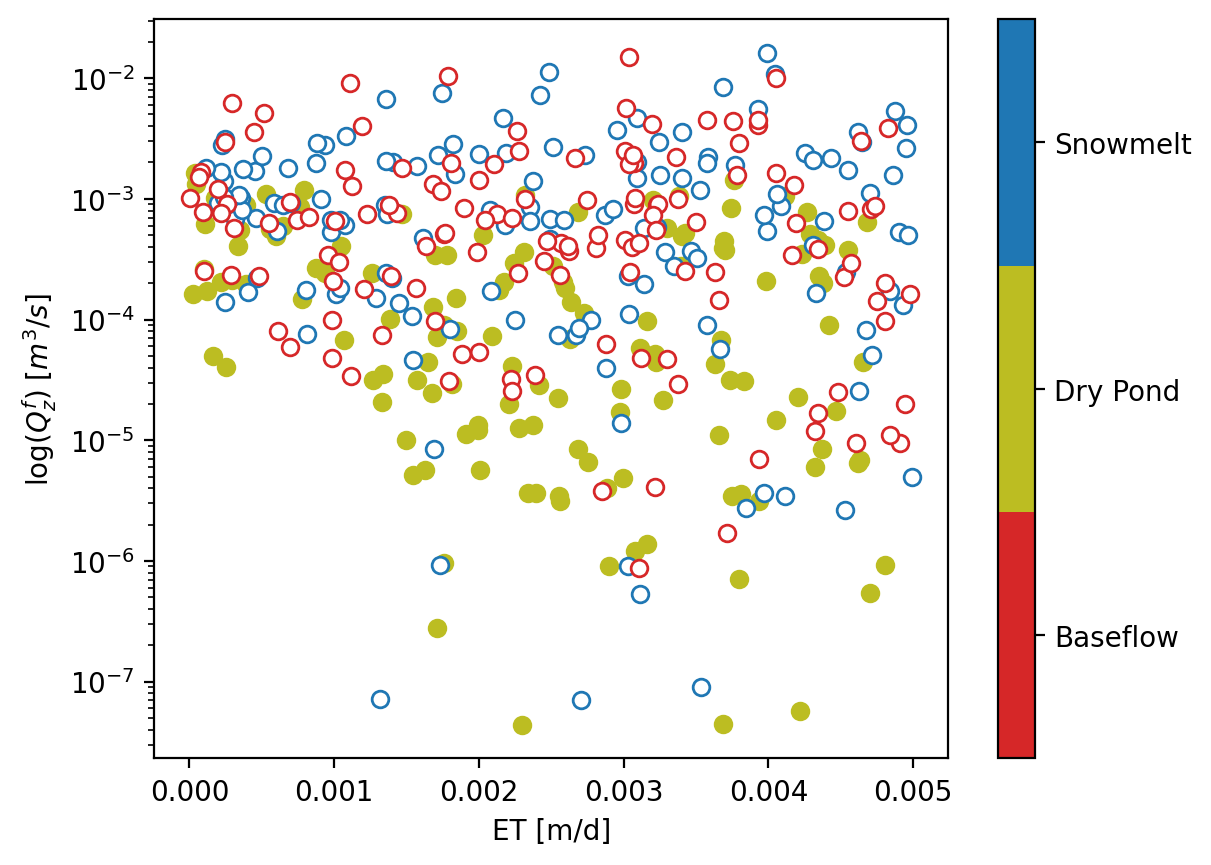

In [386]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define colors and labels for each category
colors = ['C3', 'C8', 'C0']  # Corresponding to 2: 'Snowmelt', 1: 'Dry Pond', 0: 'Baseflow'
labels = {0: 'Baseflow',1: 'Dry Pond', 2: 'Snowmelt' }
cmap = ListedColormap(colors)
bounds = [0, 1, 2, 3]  # Set boundaries for each category
norm = BoundaryNorm(bounds, cmap.N)


# Create the scatter plot
# scatter = plt.scatter(parameters['ET'][(parameters['success']==1)&(parameters['period']>-1)], all_dw_f_sum[(parameters['success']==1)&(parameters['period']>-1)], 
#                       c = parameters['period'][(parameters['success']==1)&(parameters['period']>-1)], cmap=cmap, norm=norm)
plt.yscale('log')
plt.xlabel('ET [m/d]')
plt.ylabel('$\log(Q_z^f) \ [m^3/s]$')

plt.scatter(df[(df['period'] == 1) & (df['success'] == 1) ]['ET'],df[(df['period'] == 1) & (df['success'] == 1)]['Qzf'],c =  'C8')

plt.scatter(df[(df['period'] == 2) & (df['success'] == 1) ]['ET'],df[(df['period'] == 2) & (df['success'] == 1)]['corrected_Qzf'],edgecolors='C0',c = 'white')
plt.scatter(df[(df['period'] == 0) & (df['success'] == 1) ]['ET'],df[(df['period'] == 0) & (df['success'] == 1) ]['corrected_Qzf'],edgecolors='C3',c = 'white')

#plt.legend()
# Create a color bar with appropriate labels for the periods
cbar = plt.colorbar(scatter, ticks=[0.5, 1.5, 2.5])  # Position the ticks between boundaries
cbar.ax.set_yticklabels([labels[0], labels[1], labels[2]])  # Apply labels

#plt.plot(df[(df['period'] == 1) & (df['success'] == 1)]['ET'],df[(df['period'] == 1) & (df['success'] == 1)]['Qzf'],'.')
plt.yscale('log')

#plt.title('ET Corrected $Q_z^f$')

# Show the plot
plt.show()



<>:15: DeprecationWarning: invalid escape sequence \l
<>:15: DeprecationWarning: invalid escape sequence \l
/var/folders/bc/n9nbnrrd1m1gttddqb1hzyt00000gp/T/ipykernel_38126/117692212.py:15: DeprecationWarning: invalid escape sequence \l
  plt.ylabel('$\log(Q_z^f) \ [m^3/s]$')


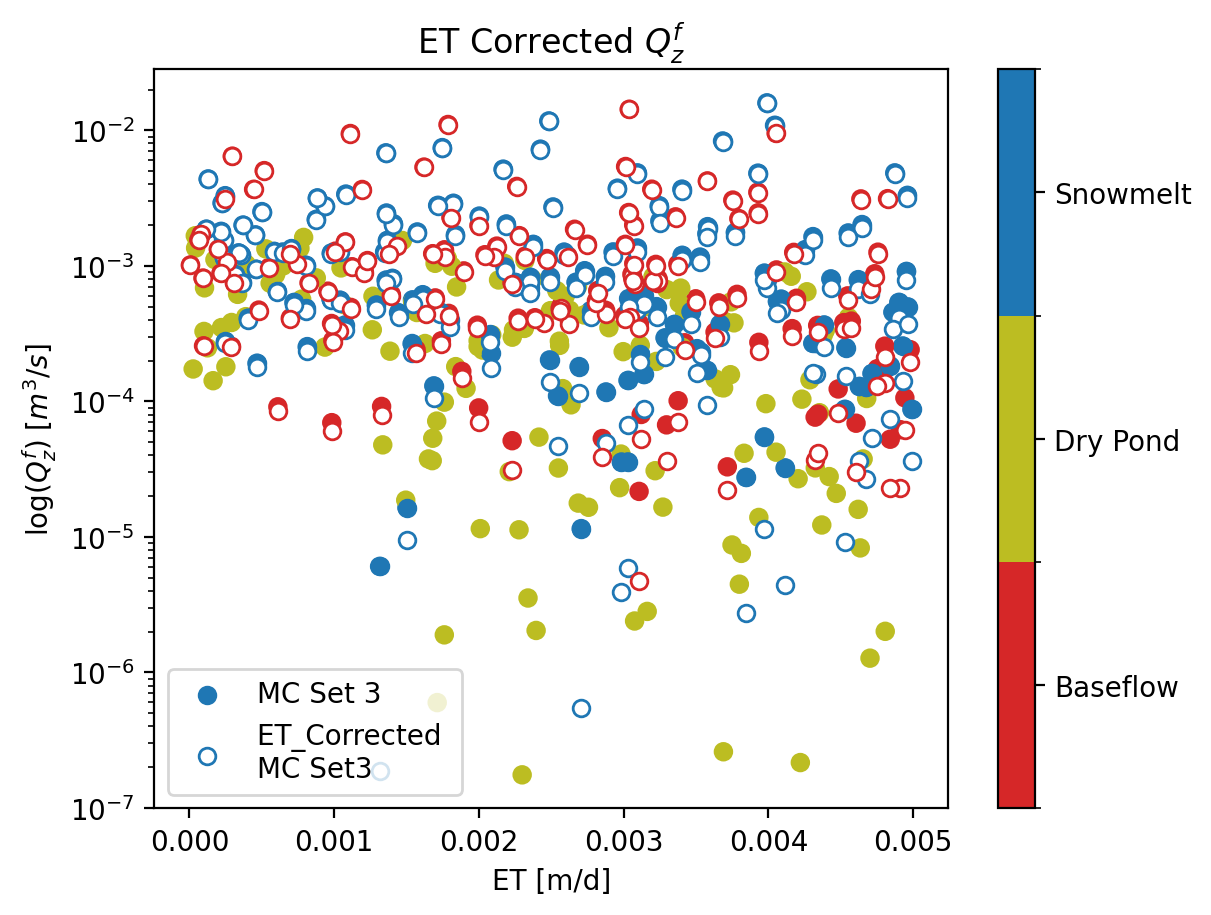

In [54]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define colors and labels for each category
colors = ['C3', 'C8', 'C0']  # Corresponding to 2: 'Snowmelt', 1: 'Dry Pond', 0: 'Baseflow'
labels = {0: 'Baseflow',1: 'Dry Pond', 2: 'Snowmelt' }
cmap = ListedColormap(colors)
bounds = [0, 1, 2, 3]  # Set boundaries for each category
norm = BoundaryNorm(bounds, cmap.N)


# Create the scatter plot
scatter = plt.scatter(parameters['ET'][(parameters['success']==1)&(parameters['period']>-1)], all_dw_f_sum[(parameters['success']==1)&(parameters['period']>-1)], c = parameters['period'][(parameters['success']==1)&(parameters['period']>-1)], cmap=cmap, norm=norm)
plt.yscale('log')
plt.xlabel('ET [m/d]')
plt.ylabel('$\log(Q_z^f) \ [m^3/s]$')

plt.scatter(df[(df['period'] == 2) & (df['success'] == 1) ]['ET'],df[(df['period'] == 2) & (df['success'] == 1)]['Qzf'],c =  'C0',label = 'MC Set 3')

plt.scatter(df[(df['period'] == 2) & (df['success'] == 1) ]['ET'],df[(df['period'] == 2) & (df['success'] == 1)]['corrected_Qzf'],edgecolors='C0',c = 'white',label = 'ET_Corrected \nMC Set3')
plt.scatter(df[(df['period'] == 0) & (df['success'] == 1) ]['ET'],df[(df['period'] == 0) & (df['success'] == 1) ]['corrected_Qzf'],edgecolors='C3',c = 'white')

plt.legend()
# Create a color bar with appropriate labels for the periods
cbar = plt.colorbar(scatter, ticks=[0.5, 1.5, 2.5])  # Position the ticks between boundaries
cbar.ax.set_yticklabels([labels[0], labels[1], labels[2]])  # Apply labels

#plt.plot(df[(df['period'] == 1) & (df['success'] == 1)]['ET'],df[(df['period'] == 1) & (df['success'] == 1)]['Qzf'],'.')
plt.yscale('log')

plt.title('ET Corrected $Q_z^f$')

# Show the plot
plt.show()



In [357]:
df['zf_change'] = (df['Qzf']-df['corrected_Qzf'])/df['Qzf']

<>:10: DeprecationWarning: invalid escape sequence \l
<>:10: DeprecationWarning: invalid escape sequence \l
/var/folders/bc/n9nbnrrd1m1gttddqb1hzyt00000gp/T/ipykernel_38126/452245505.py:10: DeprecationWarning: invalid escape sequence \l
  cbar.set_label('$\log($corrected $ Q_z^f)$')


Text(0.5, 1.0, 'Simulations for Snowmelt Period from MC Set 3')

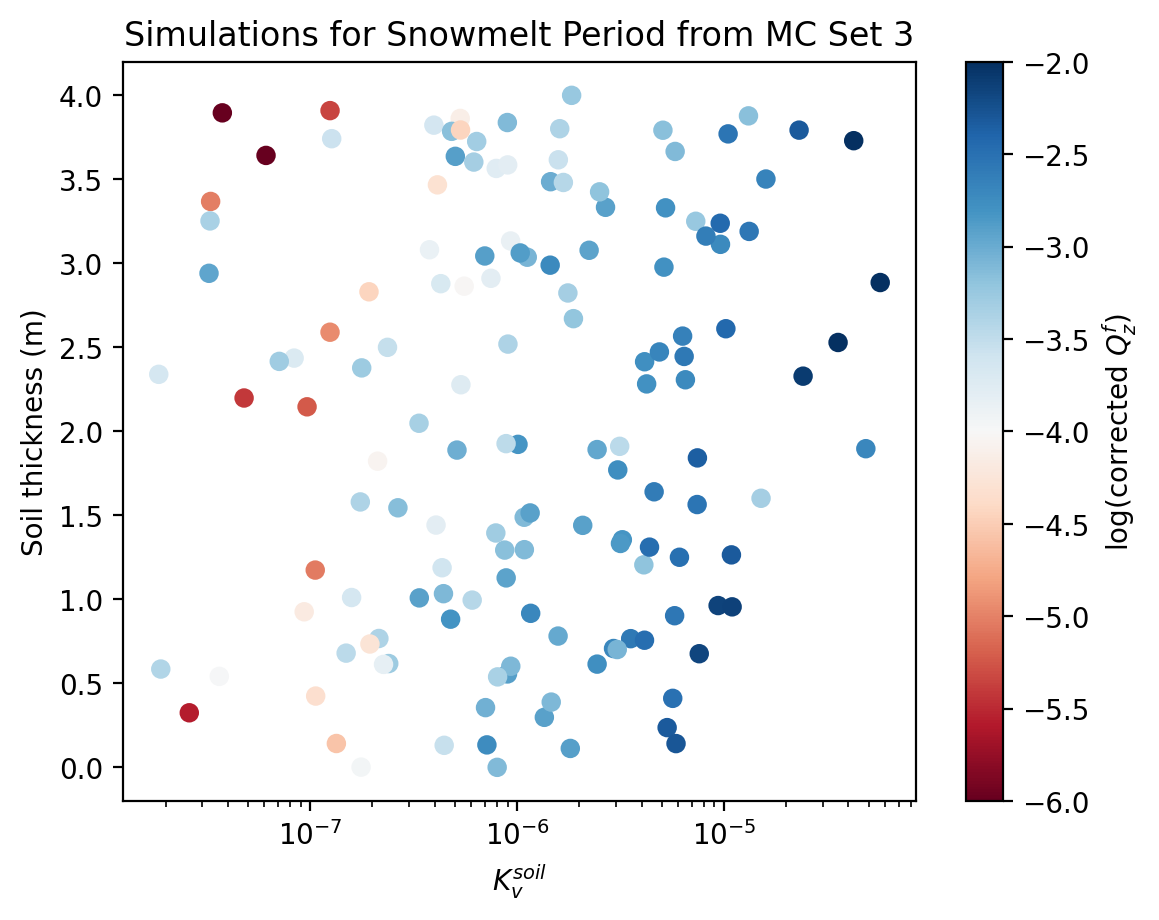

In [56]:
scatter = plt.scatter(df[(df['period'] == 2) & (df['success'] == 1)]['hk_soil']*df[(df['period'] == 2) & (df['success'] == 1)]['vka_ratio_soil'],
            df[(df['period'] == 2) & (df['success'] == 1)]['structure_ratio1']*2,
                      c = np.log10(df[(df['period'] == 2) & (df['success'] == 1)]['corrected_Qzf']),vmin = -6,vmax= -2,cmap = 'RdBu')
plt.xlabel('$K_v^{soil}$')
plt.ylabel('Soil thickness (m)')
#plt.yscale('log')
plt.xscale('log')
# Adding color bar with title
cbar = plt.colorbar(scatter)
cbar.set_label('$\log($corrected $ Q_z^f)$')

plt.title('Simulations for Snowmelt Period from MC Set 3')
